데이터 세트의 shape :  (1460, 81)

 전체 피처의 type 
  object     43
int64      35
float64     3
dtype: int64

NULL 칼럼과 그 건수 : 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


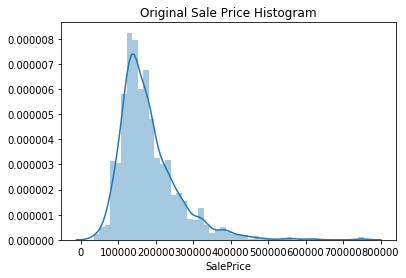

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head()

print('데이터 세트의 shape : ', house_df.shape)
print('\n 전체 피처의 type \n ', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNULL 칼럼과 그 건수 : \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

# null값이 너무 많은 피처는 드롭

plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])




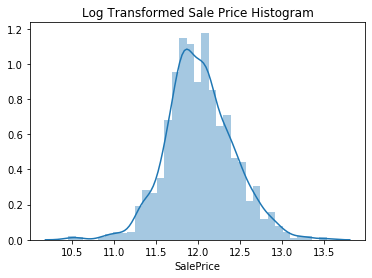

In [3]:
# 정규분포의 형태가 아니므로 로그 변환을 해준다.

plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)

house_df.fillna(house_df.mean(), inplace=True)

In [4]:
# 문자형의 null값 조사
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 type : \n', house_df.dtypes[null_column_count.index])


print('get_dummies() 수행 전 데이터 shape : ', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape : ', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('### Null 피처의 type : \n', house_df_ohe.dtypes[null_column_count.index])
print('\n')

# null 값이 없어진 것을 확인할 수 있다. 


## Null 피처의 type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object
get_dummies() 수행 전 데이터 shape :  (1460, 75)
get_dummies() 수행 후 데이터 shape :  (1460, 271)
### Null 피처의 type : 
 Series([], dtype: object)




In [5]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그 변환된 RMSE : ', np.round(rmse,3))
    return rmse


def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=156)


lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.128
Lasso 로그 변환된 RMSE :  0.176


[0.1318957657915436, 0.12750846334053045, 0.17628250556471395]

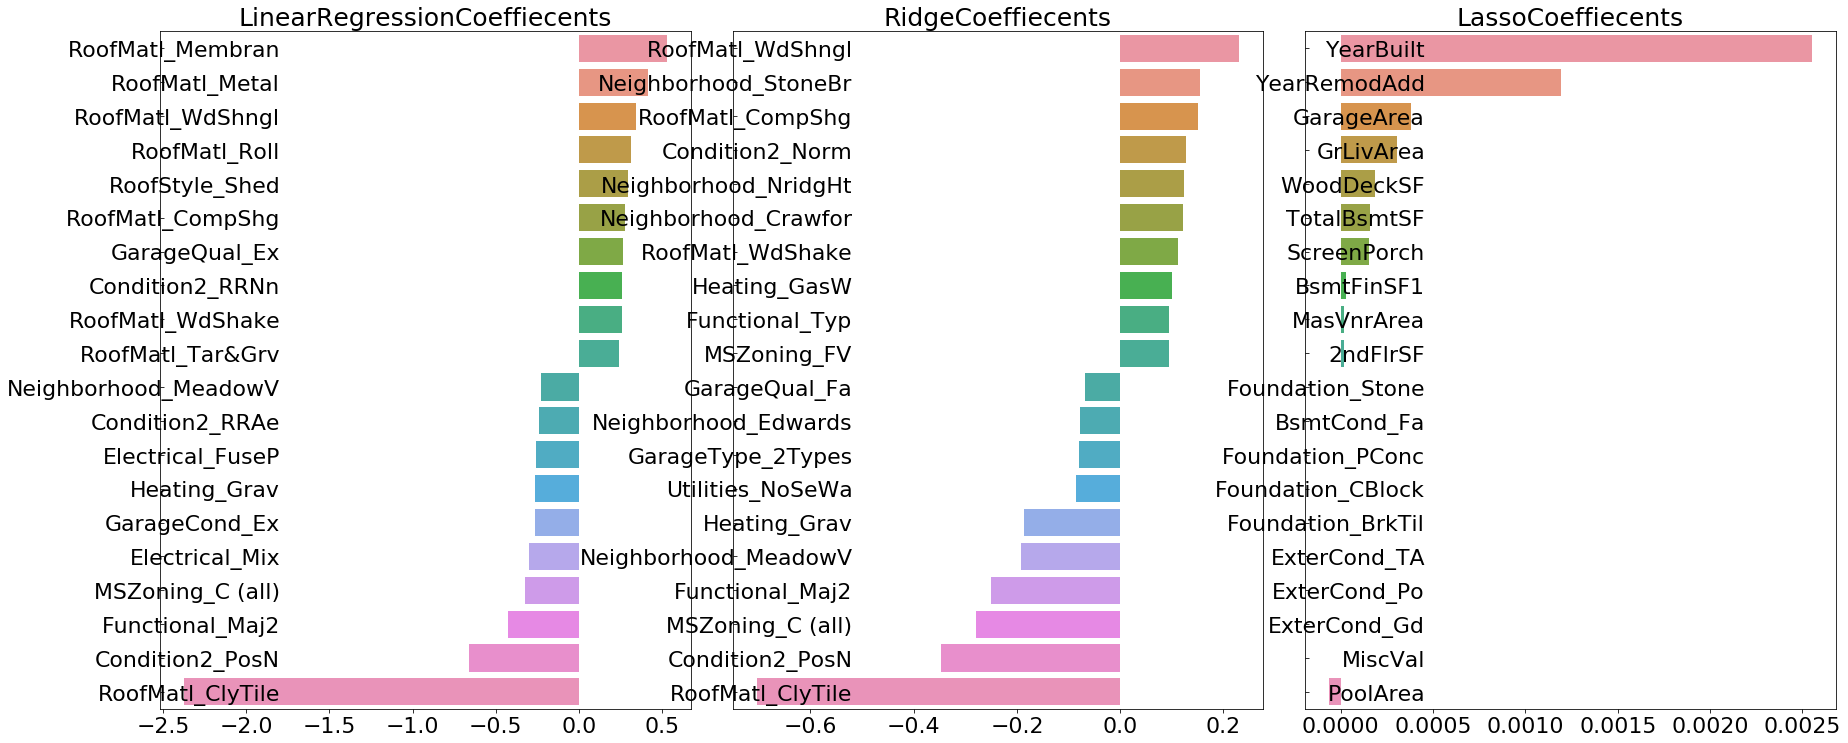

In [6]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X_features.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low


def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax = axs[i_num])
        
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [7]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        
        rmse_avg = np.mean(rmse_list)
        print('\n {} CV RMSE 값 리스트 : {}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{} CV 평균 RMSE값 : {}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

        
        
models=[lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


 LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE값 : 0.155

 Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE값 : 0.144

 Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE값 : 0.198


Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}
LinearRegression 로그 변환된 RMSE :  0.132
Ridge 로그 변환된 RMSE :  0.124
Lasso 로그 변환된 RMSE :  0.12


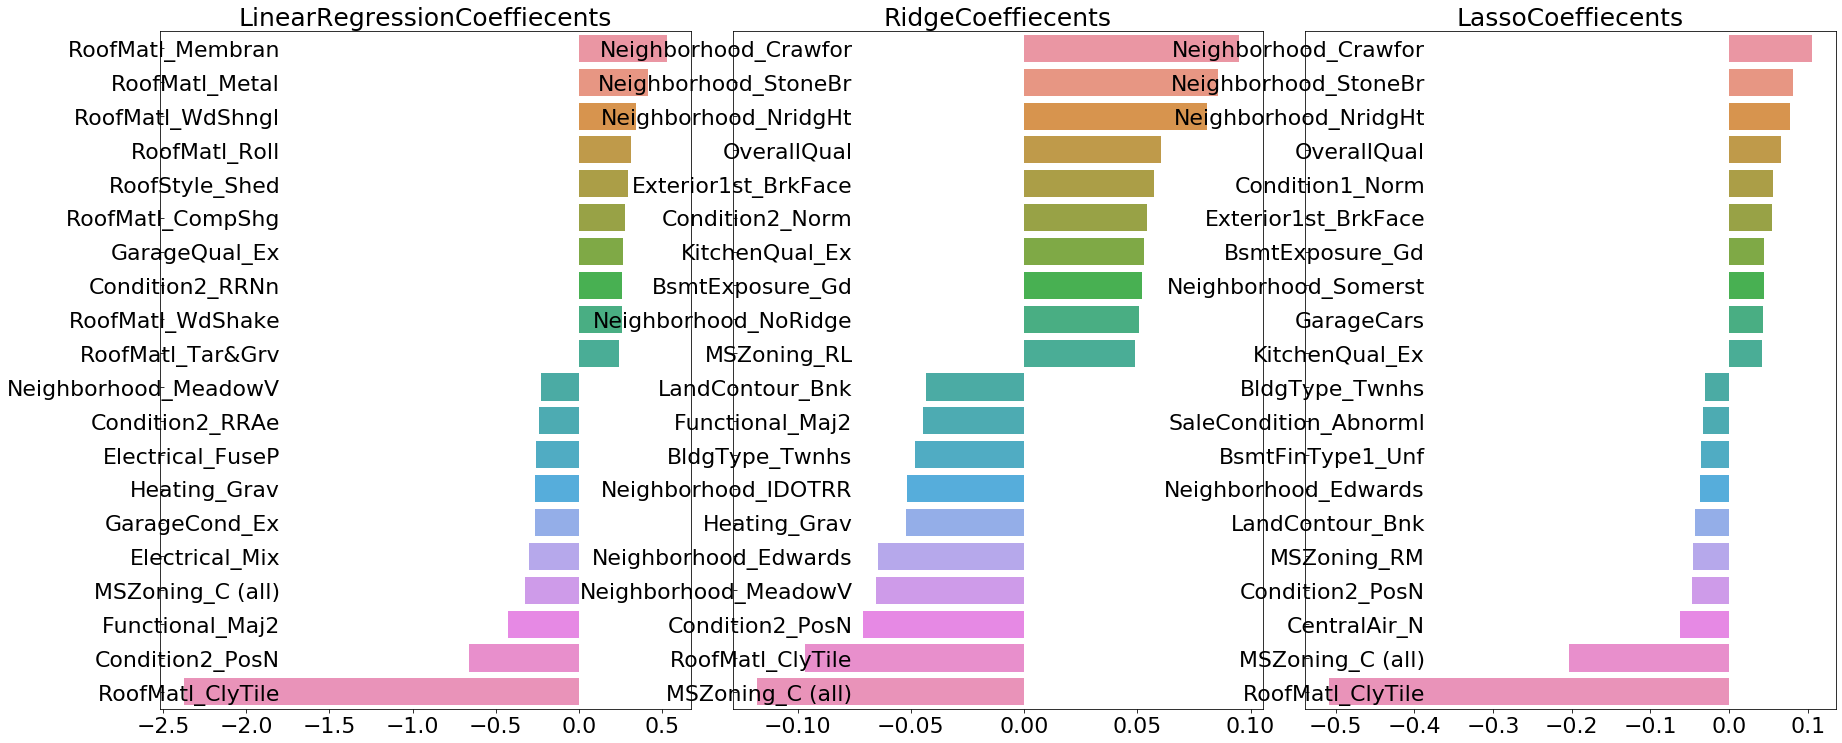

In [8]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{} 5 CV 시 최적 평균 RMSE 값 : {}, 최적 alpha : {}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))
    
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001,0.005,0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

visualize_coefficient(models)

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64
Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1276, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1251, 최적 alpha : {'alpha': 0.001}


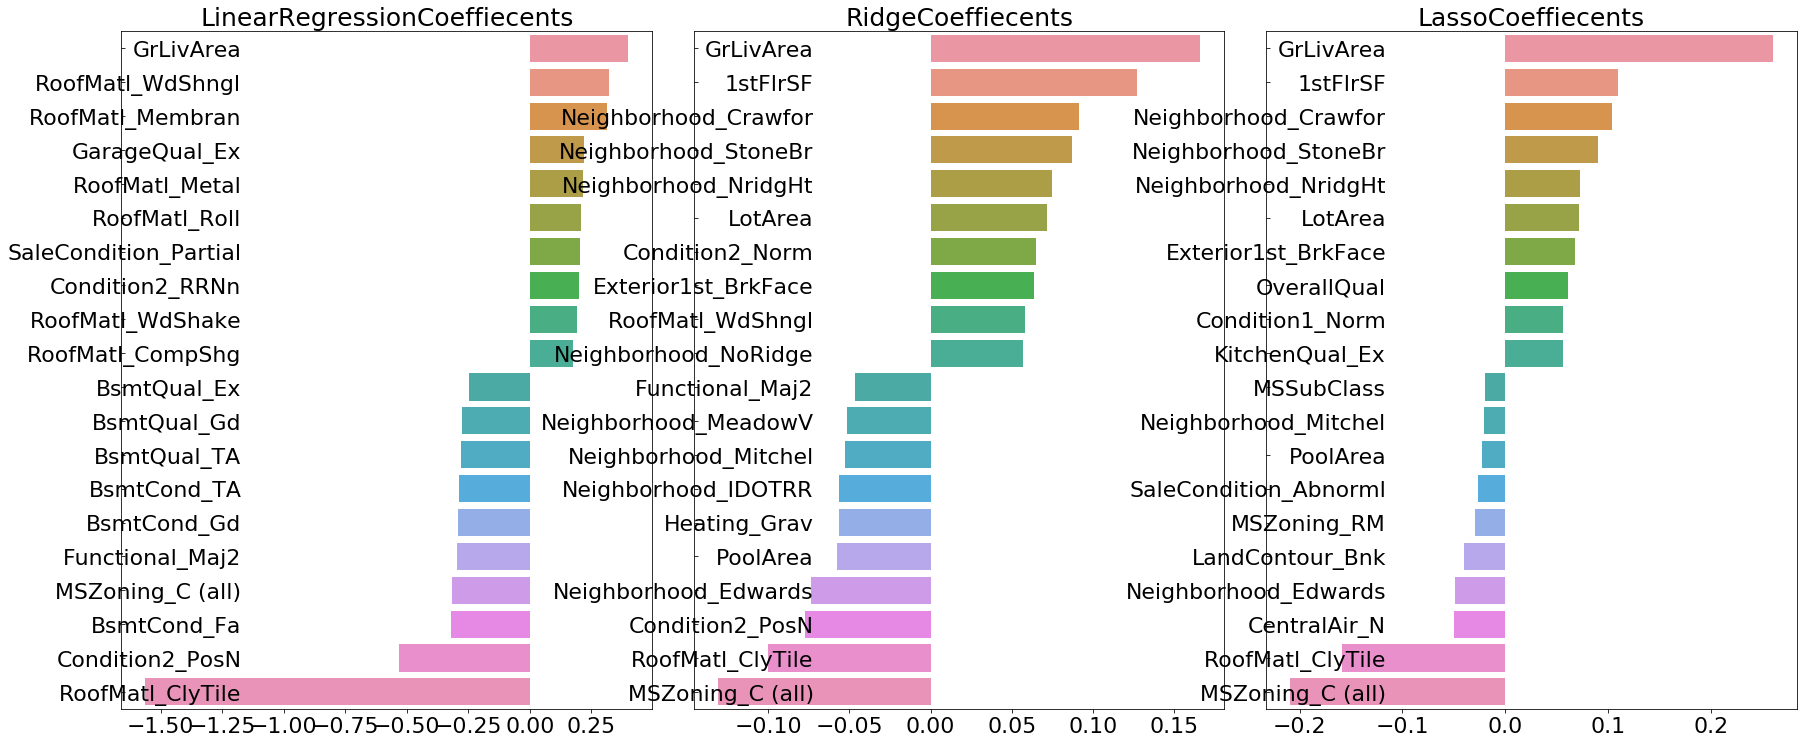

In [10]:
# 피처 데이터의 분포도를 조사한다.

from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(lambda x : skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))


house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=156)



ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001,0.005,0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

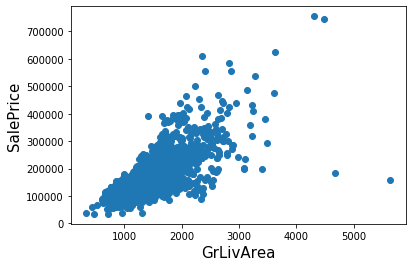

이상치 레코드 index :  [ 523 1298]
이상치 삭제 전 house_df_ohe shape :  (1460, 271)
이상치 삭제 후 house_df_ohe shape :  (1458, 271)
Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha : {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE :  0.129
Ridge 로그 변환된 RMSE :  0.103
Lasso 로그 변환된 RMSE :  0.1


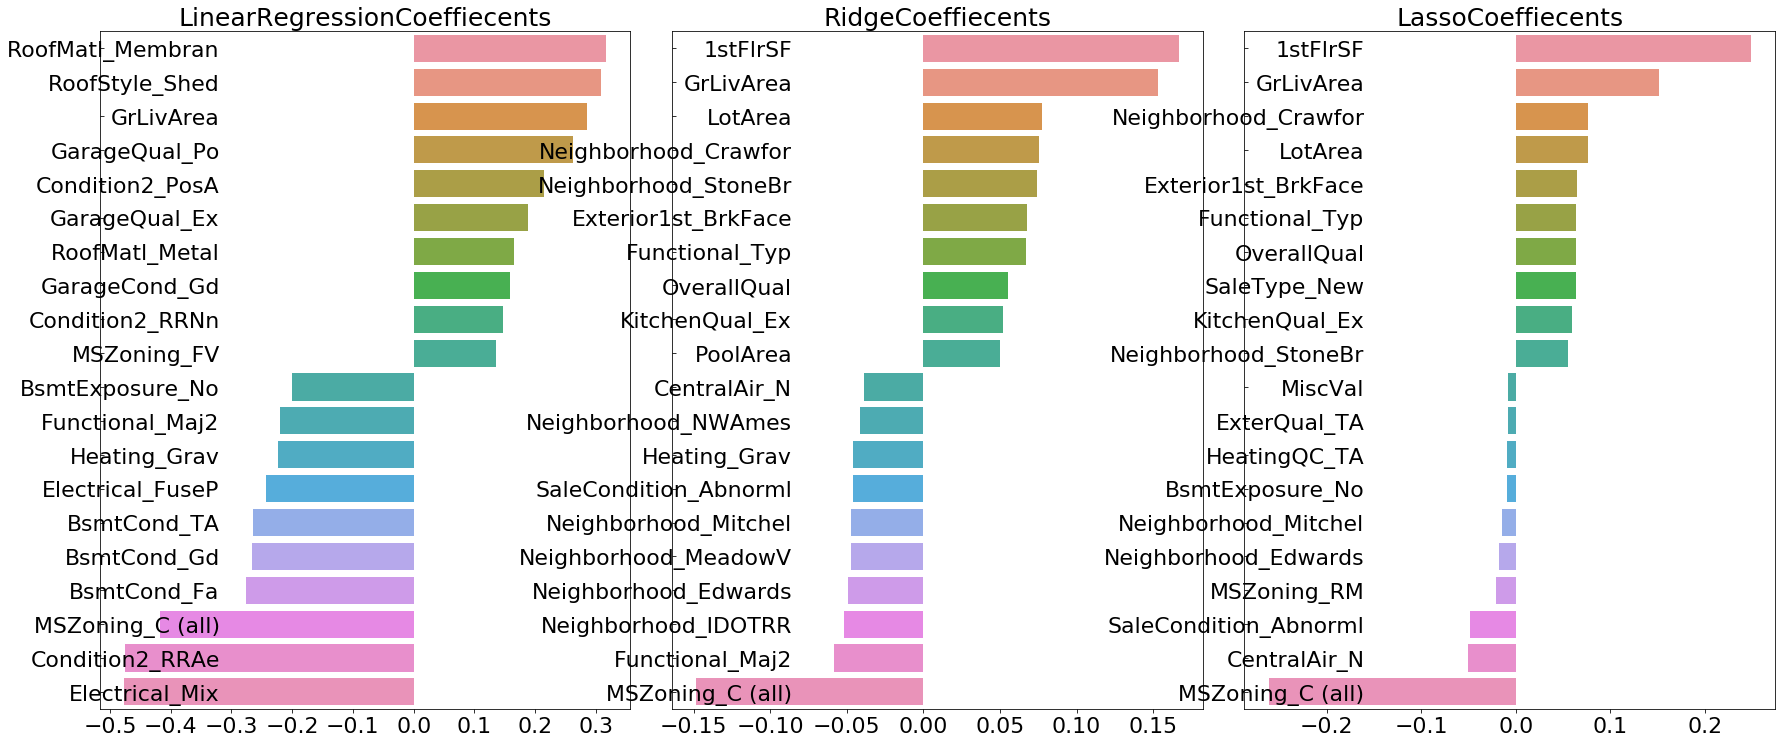

In [11]:
# 회귀계수가 높은 피처 조사.
# 주거공간과 가격의 상관관계 조사    
    
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index : ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape : ', house_df_ohe.shape)

house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape : ', house_df_ohe.shape)

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state=156)

ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)



print('\n')

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [12]:
# 회귀트리 모델 학습/예측/평가

from xgboost import XGBRegressor

xgb_params = {'n_estimators' : [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)


from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators' : [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10,n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)


# # 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
# def get_top_features(model):
#     ftr_importances_values = model.feature_importances_
#     ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns)
#     ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
#     return ftr_top20

# def visualize_ftr_importances(models):
#     # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
#     fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
#     fig.tight_layout() 
#     # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
#     for i_num, model in enumerate(models):
#         # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
#         ftr_top20 = get_top_features(model)
#         axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
#         #font 크기 조정.
#         for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
#             label.set_fontsize(22)
#         sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# # 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
# models = [best_xgb, best_lgbm]
# visualize_ftr_importances(models)

[17:15:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:15:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1151, 최적 alpha : {'n_estimators': 1000}
LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1165, 최적 alpha : {'n_estimators': 1000}


In [17]:
# 회귀 모델의 예측 결과 혼합을 통한 최종 예측

def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{} 모델의 RMSE : {}'.format(key, rmse))
        
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종혼합' : pred, 'Ridge' : ridge_pred, 'Lasso' : lasso_pred}


get_rmse_pred(preds)


xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)

최종혼합 모델의 RMSE : 0.10007930884470519
Ridge 모델의 RMSE : 0.10345177546603272
Lasso 모델의 RMSE : 0.10024170460890039
[17:01:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 모델의 RMSE : 0.09897715854093485
XGBM 모델의 RMSE : 0.10075115846547565
LGBM 모델의 RMSE : 0.1015065721553885
